# Japanese Translation with NLP


## Introduction
In this noteboook, a recurrent deep neural network will be built to translate Japanese to English.
The completed pipeline will accept Japanese text as input and return the English translation.

- **Preprocess** - You'll convert text to sequence of integers.
- **Models** Create models which accepts a sequence of integers as input and returns a probability distribution over possible translations. After learning about the basic types of neural networks that are often used for machine translation, you will engage in your own investigations, to design your own model!
- **Prediction** Run the model on English text.

In [1]:
import collections

#import helper
import os
import numpy as np
#import project_tests as tests

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1845624981876076079
]


https://github.com/odashi/small_parallel_enja

## Dataset
The corpus for this project is provided by Stanford University's Japanese English Subtitle Corpus (https://nlp.stanford.edu/projects/jesc/). THe full raw data set contains over 3 million sample sentences of Japanese and their English translation. The authors of the corpus have take the liberty to pre-tokenize the testing and training data set for ease of use.


@ARTICLE{pryzant_jesc_2017,
   author = {{Pryzant}, R. and {Chung}, Y. and {Jurafsky}, D. and {Britz}, D.},
    title = "{JESC: Japanese-English Subtitle Corpus}",
  journal = {ArXiv e-prints},
archivePrefix = "arXiv",
   eprint = {1710.10639},
 keywords = {Computer Science - Computation and Language},
     year = 2017,
    month = oct,
}                
    

### Load Data
The data is located in `data/*`. The tokenized training data sets are in `data/tokenzed/train.en` and `data/tokenized/train.ja` which contain the English sentences with their Japanese translations 

In [3]:
def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, "r", encoding="utf-8") as f:
        data = f.read()
    return data.split('\n')


In [4]:
# Load English data
en_sent_token_train = load_data('data/odashi/train.en')
en_sent_token_test = load_data('data/odashi/test.en')

# Load Japanese data
ja_sent_token_train = load_data('data/odashi/train.ja')
ja_sent_token_test = load_data('data/odashi/test.ja')

print('Dataset Loaded')


Dataset Loaded


In [5]:
#for sample_i in range(3):
#    print('Japanese Sentence Line {}:  {}'.format(sample_i + 1, ja_sent_raw[sample_i]))
#    print('English Sentence Line {}:  {}'.format(sample_i + 1, en_sent_raw[sample_i]))
    
print("-----------TRAINING DATASET-----------")
for sample_i in range(3):    
    print('Japanese Sentence Line {}:  {}'.format(sample_i + 1, ja_sent_token_train[sample_i]))
    print('English Sentence Line {}:  {}'.format(sample_i + 1, en_sent_token_train[sample_i]))
    
print("-----------TESTING DATASET-----------")
for sample_i in range(3):    
    print('Japanese Sentence Line {}:  {}'.format(sample_i + 1, ja_sent_token_test[sample_i]))
    print('English Sentence Line {}:  {}'.format(sample_i + 1, en_sent_token_test[sample_i]))
    

-----------TRAINING DATASET-----------
Japanese Sentence Line 1:  誰 が 一番 に 着 く か 私 に は 分か り ま せ ん 。
English Sentence Line 1:  i can 't tell who will arrive first .
Japanese Sentence Line 2:  多く の 動物 が 人間 に よ っ て 滅ぼ さ れ た 。
English Sentence Line 2:  many animals have been destroyed by men .
Japanese Sentence Line 3:  私 は テニス 部員 で す 。
English Sentence Line 3:  i 'm in the tennis club .
-----------TESTING DATASET-----------
Japanese Sentence Line 1:  彼 ら は つい に それ が 真実 だ と 認め た 。
English Sentence Line 1:  they finally acknowledged it as true .
Japanese Sentence Line 2:  彼 は 水泳 が 得意 で は な かっ た 。
English Sentence Line 2:  he didn 't care for swimming .
Japanese Sentence Line 3:  彼 は お 姉 さん に 劣 ら ず 親切 だ 。
English Sentence Line 3:  he is no less kind than his sister .


### Vocabulary
Since Japanese does not take into account spaces between word or vocabulary. Simple split functions will not be able to be applied to distinguish words.  The tokenized dataset provided in the JESC adds the space between words, as well as underscores to distinguish beginning of words with characters.

In [6]:
en_words_counter = collections.Counter([word for sentence in en_sent_token_train for word in sentence.split()])
ja_words_counter = collections.Counter([word for sentence in ja_sent_token_train for word in sentence.split()])

print('{} English tokens.'.format(len([word for sentence in en_sent_token_train for word in sentence.split()])))
print('{} unique English tokens.'.format(len(en_words_counter)))
print('20 Most common tokens in the English dataset:')
print('"' + '" "'.join(list(zip(*en_words_counter.most_common(20)))[0]) + '"')
print()
print('{} Japanese tokens.'.format(len([word for sentence in ja_sent_token_train for word in sentence.split()])))
print('{} unique Japanese tokens.'.format(len(ja_words_counter)))
print('20 Most common tokens in the Japanese dataset:')
print('"' + '" "'.join(list(zip(*ja_words_counter.most_common(20)))[0]) + '"')

391047 English tokens.
6634 unique English tokens.
20 Most common tokens in the English dataset:
"." "the" "i" "to" "you" "is" "he" "a" "?" "in" "it" "of" "she" "for" "my" "have" "'t" "this" "was" "me"

565618 Japanese tokens.
8774 unique Japanese tokens.
20 Most common tokens in the Japanese dataset:
"。" "は" "い" "に" "た" "を" "の" "て" "で" "な" "が" "彼" "し" "る" "私" "す" "っ" "ま" "か" "だ"


In [27]:
#ja_words_counter.most_common(150)
#en_words_counter.most_common(50)



In [36]:
import seaborn as sns
import pandas as pd

en_tokens = list(zip(*en_words_counter.most_common(15)))[0]
en_counts = list(zip(*en_words_counter.most_common(15)))[1]
jp_tokens = list(zip(*ja_words_counter.most_common(15)))[0]
jp_counts = list(zip(*ja_words_counter.most_common(15)))[1]
token_df = pd.DataFrame(list(zip(en_tokens,en_counts,jp_tokens, jp_counts)), columns=['en_tokens', 'en_counts', 'jp_tokens','jp_counts'])
token_df



,en_tokens,en_counts,jp_tokens,jp_counts
0,.,43687,。,49522
1,the,14383,は,35916
2,i,13276,い,26846
3,to,11472,に,19870
4,you,8872,た,19205
5,is,8545,を,16870
6,he,8401,の,16581
7,a,7986,て,14014
8,?,5942,で,13108
9,in,4791,な,11978


(0, 50000)

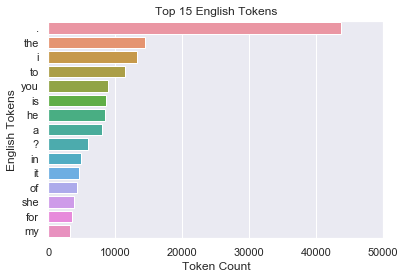

In [43]:
sns.set_style("darkgrid")
ax = sns.barplot(x="en_counts", y="en_tokens", data=token_df)
ax.set(xlabel='Token Count', ylabel='English Tokens')
ax.set_title('Top 15 English Tokens')
ax.set_xlim(0,50000)

(0, 50000)

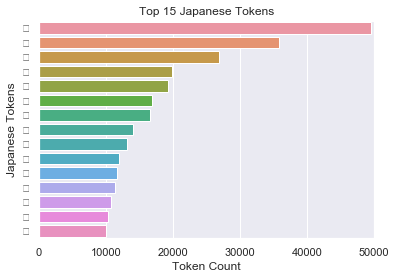

In [42]:
sns.set_style("darkgrid")
ax = sns.barplot(x="jp_counts", y="jp_tokens", data=token_df)
ax.set(xlabel='Token Count', ylabel='Japanese Tokens')
ax.set_title('Top 15 Japanese Tokens')
ax.set_xlim(0,50000)

## Preprocess
For this project, you won't use text data as input to your model. Instead, you'll convert the text into sequences of integers using the following preprocess methods:
1. Tokenize the words into ids
2. Add padding to make all the sequences the same length.

Time to start preprocessing the data...
### Tokenize (IMPLEMENTATION)
For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings.  Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

We can turn each character into a number or each word into a number.  These are called character and word ids, respectively.  Character ids are used for character level models that generate text predictions for each character.  A word level model uses word ids that generate text predictions for each word.  Word level models tend to learn better, since they are lower in complexity, so we'll use those.

Turn each sentence into a sequence of words ids using Keras's [`Tokenizer`](https://keras.io/preprocessing/text/#tokenizer) function. Use this function to tokenize `english_sentences` and `french_sentences` in the cell below.

Running the cell will run `tokenize` on sample data and show output for debugging.

In [7]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    x_tk = Tokenizer() #tokenize to the word level
    x_tk.fit_on_texts(x) #tokenize text x    
    
    return x_tk.texts_to_sequences(x), x_tk

# Tokenize Example output
text_sentences = en_sent_token_train[:3]
#    [

text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'i': 1, 'can': 2, "'t": 3, 'tell': 4, 'who': 5, 'will': 6, 'arrive': 7, 'first': 8, 'many': 9, 'animals': 10, 'have': 11, 'been': 12, 'destroyed': 13, 'by': 14, 'men': 15, "'m": 16, 'in': 17, 'the': 18, 'tennis': 19, 'club': 20}

Sequence 1 in x
  Input:  i can 't tell who will arrive first .
  Output: [1, 2, 3, 4, 5, 6, 7, 8]
Sequence 2 in x
  Input:  many animals have been destroyed by men .
  Output: [9, 10, 11, 12, 13, 14, 15]
Sequence 3 in x
  Input:  i 'm in the tennis club .
  Output: [1, 16, 17, 18, 19, 20]


### Padding (

In [8]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    if length is None:
        length = max([len(sentence) for sentence in x]) # set length equal to max sequence when there is no designated length value
    padded_sequence = pad_sequences(x, maxlen=length, padding='post')  # add 0's after sequence until sequence reaches max length
    return padded_sequence

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 3 4 5 6 7 8]
  Output: [1 2 3 4 5 6 7 8]
Sequence 2 in x
  Input:  [ 9 10 11 12 13 14 15]
  Output: [ 9 10 11 12 13 14 15  0]
Sequence 3 in x
  Input:  [ 1 16 17 18 19 20]
  Output: [ 1 16 17 18 19 20  0  0]


### Preprocess Pipeline
Your focus for this project is to build neural network architecture, so we won't ask you to create a preprocess pipeline.  Instead, we've provided you with the implementation of the `preprocess` function.

In [9]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x) # tokenize input x
    preprocess_y, y_tk = tokenize(y) # tokenize input y

    preprocess_x = pad(preprocess_x) # pad input tokenized x
    preprocess_y = pad(preprocess_y) # pad input tokenized y

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1) # add third dimension '1'

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_ja_sentences, preproc_en_sentences, ja_tokenizer, en_tokenizer = preprocess(ja_sent_token_train, en_sent_token_train)
preproc_ja_sentences_test, preproc_en_sentences_test, ja_tokenizer_test, en_tokenizer_test = preprocess(ja_sent_token_test, en_sent_token_test)


max_en_sequence_length = preproc_en_sentences.shape[1]
max_ja_sequence_length = preproc_ja_sentences.shape[1]
en_vocab_size = len(en_tokenizer.word_index)
ja_vocab_size = len(ja_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_en_sequence_length)
print("Max Japanese sentence length:", max_ja_sequence_length)
print("English vocabulary size:", en_vocab_size)
print("Japanese vocabulary size:", ja_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max Japanese sentence length: 16
English vocabulary size: 6547
Japanese vocabulary size: 8774


### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want.  We want the French translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the French translation.  You'll be using this function to better understand the output of the neural network.

In [10]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


## Training the Model



In [ ]:
def rnn_model(input_shape, output_sequence_length, ja_vocab_size, en_vocab_size):
    
    
    #parameters
    learning_rate = 0.001
    
    # Build the layers    
    model = Sequential()
    
    #Embedding:
    model.add(Embedding(input_dim=ja_vocab_size, output_dim=1000,  input_length=output_sequence_length, input_shape=input_shape[1:]))
   

    #1 : ENCODER   Add bidirectional recurrent layer
    model.add(Bidirectional(GRU(1000)))
    model.add(RepeatVector(output_sequence_length))
              
              
   # Decoder
    model.add(Bidirectional(GRU(1000, return_sequences=True)))
    model.add(TimeDistributed(Dense(2000, activation='relu')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(en_vocab_size, activation='softmax')))
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    print(model.summary())
    return model

print('rnn_model')
# Train the final model
# Reshaping the input
tmp_x = pad(preproc_ja_sentences, max_en_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_en_sentences.shape[-2]))

# Train the neural network
rnn_model = rnn_model(
    tmp_x.shape,
    max_en_sequence_length,
    ja_vocab_size,
    en_vocab_size)
rnn_model.fit(tmp_x, preproc_en_sentences, batch_size=1024, epochs=10, validation_split=0.2)

# Print prediction(s)
print(logits_to_text(rnn_model.predict(tmp_x[:1])[0], en_tokenizer))

In [30]:
def bidirectional_rnn_dropout_model(input_shape, output_sequence_length, ja_vocab_size, en_vocab_size):
    
    learning_rate = 0.001
    input_seq = Input(shape=(input_shape[1:]))
    # Embedding() : https://keras.io/layers/embeddings/
    embed = Embedding(input_dim=ja_vocab_size, output_dim=en_vocab_size,  input_length=output_sequence_length)(input_seq) 
   
    #1 : Add bidirectional recurrent layer
    bidir_rnn1 = Bidirectional(GRU(256, activation='relu',return_sequences=True, implementation=2,name='bidir_rnn'), merge_mode='concat')(embed)
    #1 Dropout between hidden layers
    rnn_drop1 = Dropout(0.2)(bidir_rnn1)
    
    #2 : Add bidirectional recurrent layer
    bidir_rnn2 = Bidirectional(GRU(128, activation='relu',return_sequences=True, implementation=2,name='bidir_rnn'), merge_mode='concat')(rnn_drop1)
    #2 Dropout between hidden layers
    rnn_drop2 = Dropout(0.2)(bidir_rnn2)
    
    #3 : Add bidirectional recurrent layer
    bidir_rnn3 = Bidirectional(GRU(64, activation='relu',return_sequences=True, implementation=2,name='bidir_rnn'), merge_mode='concat')(rnn_drop2)
    #3 Dropout between hidden layers
    rnn_drop3 = Dropout(0.2)(bidir_rnn3)
    
    
    # : Add a TimeDistributed(Dense(output_dim)) layer
    logits = TimeDistributed(Dense(en_vocab_size, activation = 'softmax'))(rnn_drop3)
    
    model = Model(inputs = input_seq, outputs = logits)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    print(model.summary())
    return model

print('bidirectional_rnn_dropout_model')
# Train the final model
# Reshaping the input
tmp_x = pad(preproc_ja_sentences, max_en_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_en_sentences.shape[-2]))

# Train the neural network
bidirectional_rnn_dropout_model = bidirectional_rnn_dropout_model(
    tmp_x.shape,
    max_en_sequence_length,
    ja_vocab_size,
    en_vocab_size)
bidirectional_rnn_dropout_model.fit(tmp_x, preproc_en_sentences, batch_size=1024, epochs=10, validation_split=0.2)

# Print prediction(s)
print(logits_to_text(bidirectional_rnn_dropout_model.predict(tmp_x[:1])[0], en_tokenizer))

bidirectional_rnn_dropout_model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 15)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 15, 6547)          57443378  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 15, 512)           10450944  
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 512)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 15, 256)           492288    
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 256)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 15, 128)

In [27]:
print(ja_sent_token_train[:1])
print(en_sent_token_train[:1])

['誰 が 一番 に 着 く か 私 に は 分か り ま せ ん 。']
["i can 't tell who will arrive first ."]


In [31]:
#save the model
bidirectional_rnn_dropout_model.save('model/bidirectional_rnn_dropout_model2.h5')

In [23]:
#model = load_model('bidirectional_rnn_dropout_model2.h5')

In [25]:
# Reshaping the input
#test_x = pad(preproc_ja_sentences_test, max_en_sequence_length)
#test_x = tmp_x.reshape((-1, preproc_en_sentences_test.shape[-2]))

for i in range(3):
    # Print prediction(s)
    print(ja_sent_token_test[i])
    print(en_sent_token_test[i])
    print(logits_to_text(bidirectional_rnn_dropout_model.predict(test_x[:1])[i], en_tokenizer))
    

0
1
2
